In [1]:
# Disable GPU for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Concatenate, Flatten
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy

# Aims of this practical session

* To define and use different deep models using the Keras Models API, which is more general than the Sequential API we have used so far

* To examine the effect of batch normalisation and skip-forward connections on learning with deep networks. 

* To examine the effect of different amounts of regularisation on the same architecture, and to plot a graph of training and validation error as a function of the amount of regularisation

* To explore the MNIST dataset and plot learning curves to estimate error rates as a function of training set size

* To do your own exploration of applying different architectures to the MNIST data (and possibly also to the CIFAR data during the week)

# Keras datasets

Several well known datasets are provided with the Keras implementation, and can be imported and easily used.

The MNIST dataset is a famous and has been used as a testbed of machine learning algorithms for more than 25 years. 

Look at the Keras documentation (at Keras.io ) to find out about other datasets included with Keras.  There is an interesting dataset called fashion_MNIST which is a plug-in replacement for the MNIST dataset, but which may have very different properties (it is grey-scale images). (It is possible that you may need to download this from the web if you want to use it. ) 

In [4]:
type(mnist)

module

In [5]:
# look at the Keras documentation on datasets at 
(x_train,y_train),(x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape, y_train.shape  # both x_train and y_train are numpy arrays

((60000, 28, 28), (60000,))

In [7]:
# we need to reshape the training data to have 4D, since we want each digit to be read as an image
# with only one colour channel

x_train = x_train.reshape([60000,28,28,1])
x_test = x_test.reshape([10000,28,28,1])

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
# to use softmax, we need to alter the class representations from integers to 'one-hot' 

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_train_one_hot.shape, y_test_one_hot.shape

((60000, 10), (10000, 10))

In [9]:
# let's take a closer look at the one-hot representations

# this code prints the class labels in the left-most column, 
# followed by the one-hot representation. 

# Note that the one-hot representation has a 1 at only one position in 
# each row: the position corresponding to the class index. 
# Only one element is "hot" for each example. 

np.hstack( [y_train[:10].reshape([10,1]), y_train_one_hot[:10,:]] )

array([[5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

Let's look at some of the digits. 

In [10]:
def plot_images(images_to_plot, titles=None, ncols=6, thefigsize=(18,18)):
    
    n_images = images_to_plot.shape[0]
    
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
 
    if n_images == 1:
        ax.imshow( images_to_plot[0,:,:,0], cmap=cm.Greys ) 
        ax.axis('off')  
        if titles is not None:
            ax.set_title(titles[0])
    else:
        ax = ax.flatten()
        for i in range(n_images):
            ax[i].imshow( images_to_plot[i,:,:,0], cmap=cm.Greys ) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
            ax[i].axis('off')  
            if titles is not None:
                ax[i].set_title(titles[i])
    

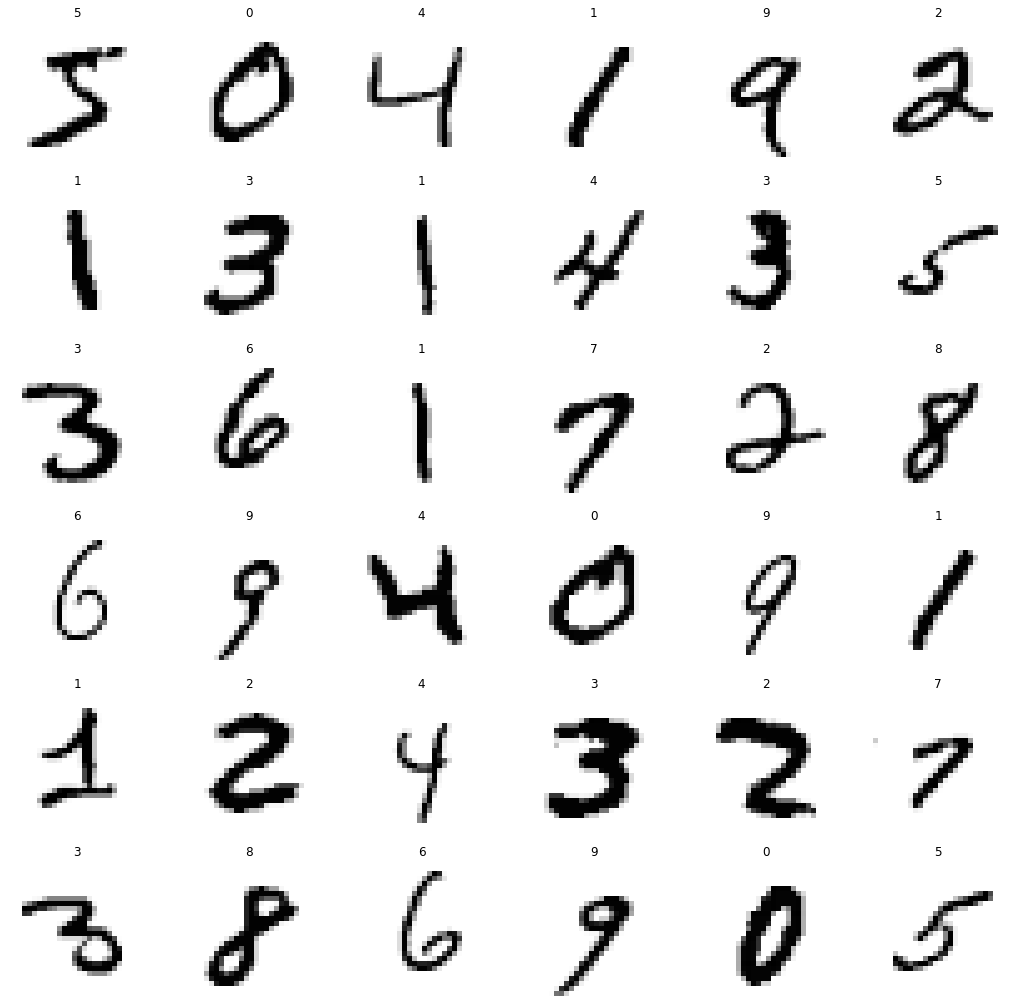

In [11]:
plot_images( x_train[:36,:,:,:], titles= y_train[:36])

Classifying these isn't easy: look how different the 4s are from each other, and the 5s. 

Take a moment to look at the images carefully: what do you think are the difficulties of classifying these with a neural net?  How large are the features that you would need to use? 

# Neural network models for MNIST classification

It is best not to use the entire MNIST dataset as a training set because you will be training for the whole of the practical class. You will learn much more by training repeatedly on smaller subsets, and examining the effect of using different models and parameters. 

In [12]:
# This model is specified using the Keras Sequential API, which allows one to specify a network which is a 
# linear sequence of layers, the output of one being the input of the next
# Please look at the Keras documentation on the API

# we have specified this model in finer detail than last week
# 

model=Sequential()
model.add(Conv2D(6,(3,3),padding='same',input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(Conv2D(6,(3,3),padding='same'))  # A depth of only 6 convolutional filters here: do we need more to keep the information? 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')) 
# you might want to try adding more convolutions and pooling here 
model.add(Flatten()) # reshapes the square array of the image into a vector
model.add(Dense(100)) # this is a pure linear transform
model.add(BatchNormalization())   
model.add(Activation('tanh'))     # Activation is a layer that applies a non-linearity to its inputs
model.add(Dense(100))
#model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dense(100))
#model.add(BatchNormalization()) # we can drop BatchNormalization into or out of the model at will. 
model.add(Activation('tanh'))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dense(100))
#model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         60        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         330       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1176)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [14]:
#model.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
import os
import shutil
# Create the root log directory to record metrics using tensorboard callback
logdir = "tensorboard_image_logs"
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)

In [17]:
# Initialize
%load_ext tensorboard

In [18]:
# Run
%tensorboard --logdir tensorboard_image_logs 

Reusing TensorBoard on port 6008 (pid 6000), started 5 days, 12:49:08 ago. (Use '!kill 6000' to kill it.)

In [19]:
import datetime
# Create tensorboard callback that tracks metrics at each epoch
logdir = os.path.join("tensorboard_image_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_epoch_callback = tf.keras.callbacks.TensorBoard(logdir, write_images=True, histogram_freq=1)

In [15]:
train_size = 4096

In [16]:
index = list(range(0, train_size, 30))

In [17]:
selected_samples =  (x_train[:train_size,:,:,:])[index]
selected_labels = (y_train_one_hot[:train_size,:])[index]
selected_labels_orig = (y_train[:train_size])[index]

In [18]:
# Instantiate an optimizer.
optimizer = RMSprop()
# Instantiate a loss function.
loss_fn = CategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(( x_train[:train_size,:,:,:].astype(float),
                                                    y_train_one_hot[:train_size,:].astype(float)))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.batch(batch_size)


# Iterate over epochs.
epochs = 40

# Save loss at each batch of sample 30 in the batch
J_grid = np.zeros([epochs, len(selected_samples)])

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    y_pred = model.predict(selected_samples)
    for i in range(0, len(selected_samples)):
        J_grid[epoch][i] = loss_fn([selected_labels[i]], y_pred[i])
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            #print(y_batch_train)
            #print('logits: ', logits)

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        
        # Log every 200 batches.
        #if step % 8 == 0:
        #    print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        #    print('Seen so far: %s samples' % ((step + 1) * 64))
    print('Training loss (for epoch %s) : %s ' %(epoch, float(loss_value)))


Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training loss (for epoch 0) : 1.5638349056243896 
Start of epoch 1
Training loss (for epoch 1) : 1.5149109363555908 
Start of epoch 2
Training loss (for epoch 2) : 1.4990102052688599 
Start of epoch 3
Training loss (for epoch 3) : 1.478173017501831 
Start of epoch 4
Training loss (for epoch 4) : 1.4905915260314941 
Start of epoch 5
Training loss (for epoch 5) : 1.4774839878082275 
Start of epoch 6
Training loss (for epoch 6) : 1.4767699241638184 
Start of epoch 7
Training loss (for epoc

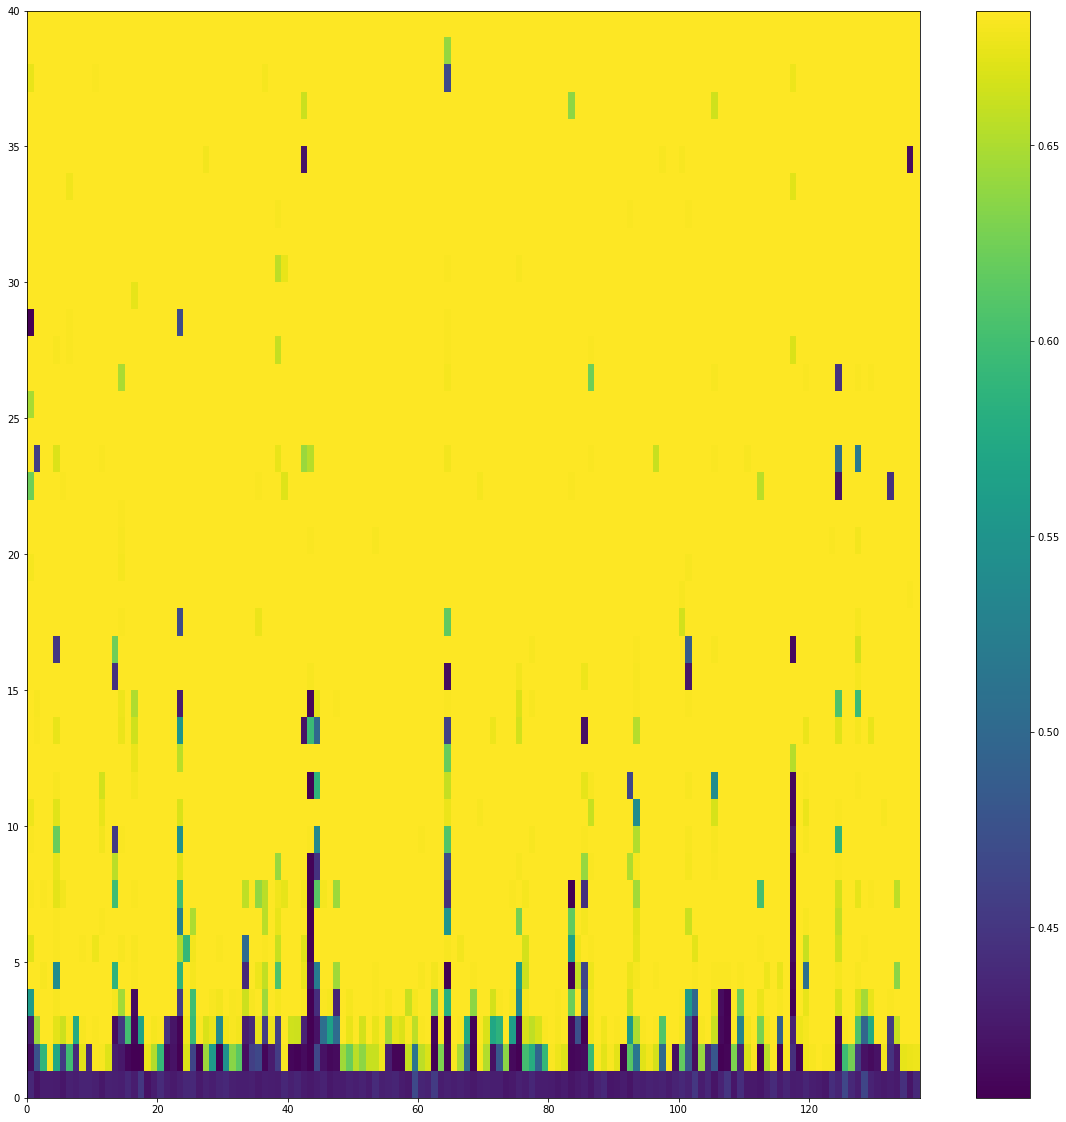

In [30]:
plt.figure(figsize = (20,20))
plt.imshow(1. /J_grid, origin='lower', extent=[0, len(selected_samples), 0, epochs], interpolation='nearest', aspect='auto')
plt.colorbar()

In [31]:
np.where(J_grid == J_grid.max())

(array([6]), array([43]))

In [42]:
print(J_grid.shape)

conv_index = [] 
for i in range(0,len(index)):
    conv_index.append(np.argmin(J_grid[:, i]))
min_conv = min(conv_index)
max_conv = max(conv_index)
print('Min epoch convergence ', min_conv)
print('Max epoch convergence ', max_conv)
sort_index = np.argsort(np.asarray(conv_index))
s_J_grid = J_grid[:, sort_index]
np.asarray(conv_index)[sort_index]

(40, 137)
Min epoch convergence  14
Max epoch convergence  39


array([14, 17, 18, 18, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32,
       33, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39,
       39])

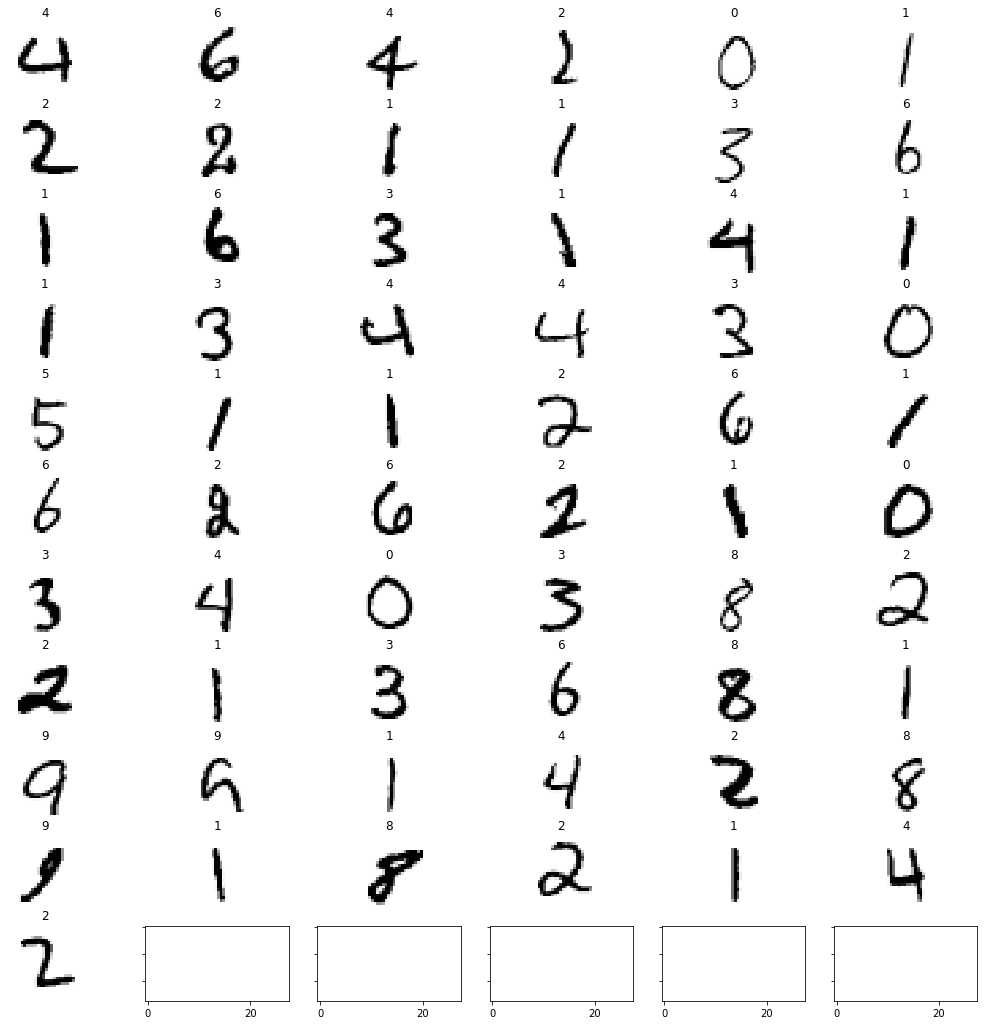

In [46]:
# Converging faster
indices = list(np.where(np.asarray(conv_index) <= (max_conv+min_conv)/2)[0])
plot_images(selected_samples[indices,:,:,:],ncols=6,titles= selected_labels_orig[indices])


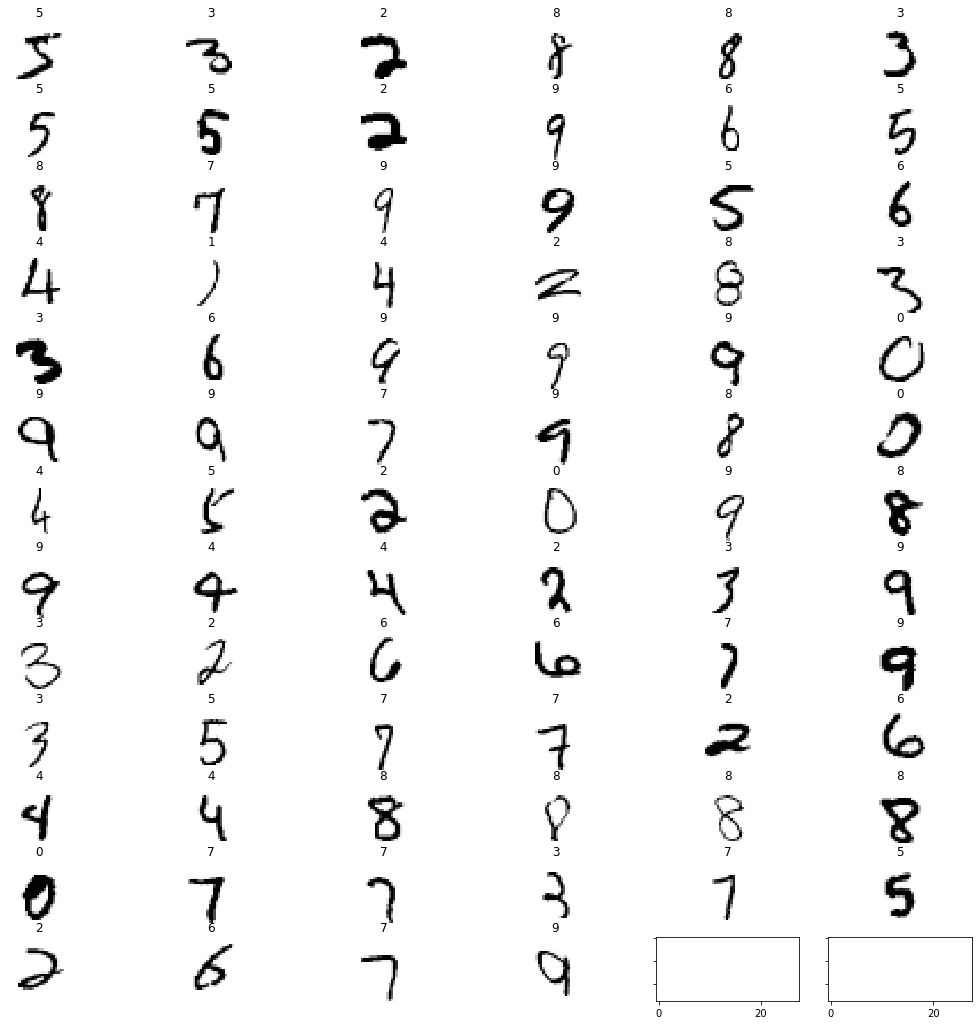

In [47]:
# Converging slower
indices = list(np.where(np.asarray(conv_index) >= (max_conv+min_conv)/2)[0])
plot_images(selected_samples[indices,:,:,:],ncols=6,titles= selected_labels_orig[indices])

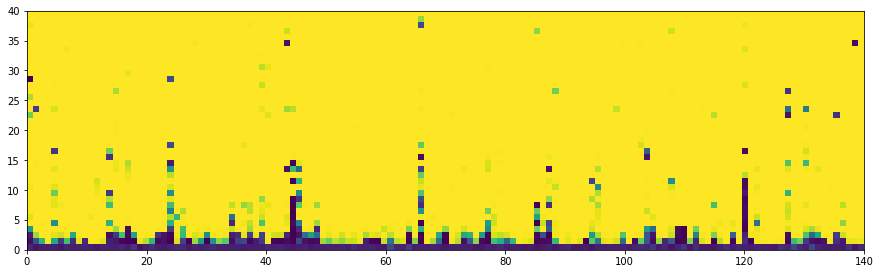

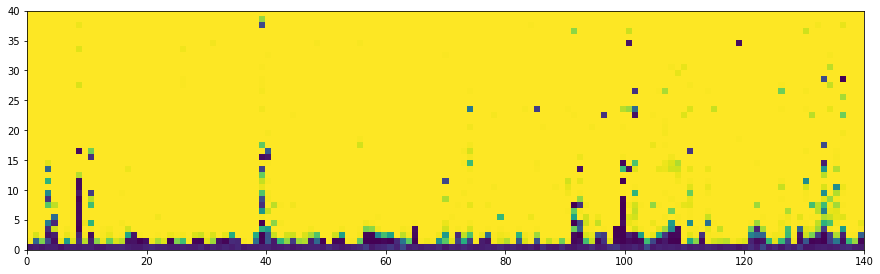

In [48]:
fig1, ax1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(15)
img1 = ax1.imshow(1. /J_grid, origin='lower', extent=[0, 140, 0, epochs])
#fig1.colorbar(img1)

plt.show()
fig2, ax2 = plt.subplots(1,1)
fig2.set_figheight(15)
fig2.set_figwidth(15)
img2 = ax2.imshow(1. /s_J_grid, origin='lower', extent=[0, 140, 0, epochs])
#fig2.colorbar(img2)
plt.show()